<a href="https://colab.research.google.com/github/dac1997/MuonLifetimeExperience/blob/main/Simulation_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of the baseline (background) for the muon lifetime experiment

In [ ]:
# Diego Alberto Coloma Borja, 2023
#python 3

#import libraries
from random import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as spicy
from scipy import stats
from scipy.optimize import curve_fit
from IPython.display import clear_output

%matplotlib inline

### Definition of the functions that are used to create the simulation and analyze the results given

In [ ]:
def recta(x, a):
    return a

def simulation_fitting(baseline, numberofbins=2048, cuts=1200, create_pictures="no"):
    ''' function that simulates an uniform detection of background data
        (randomly allocated)
        Basically, it receives a baseline value of the background
        to simulate and simulates a uniform distribution with statistical
        fluctuations

        requires numpy, scipy packages( pip install numpy scipy )'''

    numberofentries= int(numberofbins*baseline)
    bines=np.linspace(0,1,numberofbins+1)

    #create data so a histogram will count around (baseline) counts for a range (0,1)
    array=[random() for j in range(numberofentries)]

    #initialize histogram
    fig=plt.gcf()
    fig.set_size_inches(12,8)

    #create simulated distribution histogram
    counts, _ , _ = plt.hist(array, bins=bines,
                                   histtype= u'step',
                                   label="simulated signal")

    #fit a line to the simulated baseline
    bin_centers    = (bines[:-1] + bines[1:])/2

    reduced_counts = counts[cuts:]
    reduced_bin    = bin_centers[cuts:]

    mean         = np.mean(counts)
    std_dev      = np.std(counts)
    mean_redux   = np.mean(reduced_counts)
    std_dev_redux= np.std(reduced_counts)

    reduced_fitting,_ = curve_fit(recta, reduced_bin, reduced_counts)
    fitting, _        = curve_fit(recta, bin_centers, counts)

    intercept        = fitting[0]
    intercept_redux  = reduced_fitting[0]

    intercept_err       = np.sqrt(np.sum((np.array(counts)-intercept)**2)/len(counts))
    intercept_err_redux = np.sqrt(np.sum((np.array(reduced_counts)-intercept_redux)**2)/len(reduced_counts))

    # format and show graph (if requested)
    if create_pictures=="yes":
        plt.plot(reduced_bin,reduced_bin*0 +intercept_redux,
                 label='y={:.5f}x+{:.3f}'.format(0,intercept_redux),
                 color='orange', linewidth=4)
        plt.ylim(counts.min()*0.95, counts.max()*1.05)
        plt.xlim(-0.01,1.01)
        plt.legend(fontsize=12)
        plt.show()
    plt.close()

    return [mean, std_dev, intercept, intercept_err,
            mean_redux, std_dev_redux,intercept_redux, intercept_err_redux]


def pull_sim_statistics(baseline,n_sims, cut=1200, verbose="yes"):

    col_names=["Arithmetic_Mean","Standard_Deviation",
               "fit_Baseline","fit_Error",
               "Arithmetic_Mean_red","Standard_Deviation_red",
               "fit_Baseline_red", "fit_Error_red"]
    rows =[]
    for i in range(n_sims):
        if verbose == "yes":
            print("Running sim #", i+1)
        results = simulation_fitting(baseline,2048,cut)
        rows.append(results)
        if verbose == "yes":
            print("Average for sim # %i \n"%(i+1),
                  "Arithmetic Mean Method: %f \n"%results[0],
                  "Line Fit Method:        %f \n"%results[2])
        clear_output(wait='True')

    df=pd.DataFrame(rows,columns=col_names)
    df["arith_Pull"]  = (df["Arithmetic_Mean"]-baseline)/df["Standard_Deviation"]
    df["fit_Pull"]    = (df["fit_Baseline"]-baseline)/df["fit_Error"]
    df["arith_Pull_red"]  = (df["Arithmetic_Mean_red"]-baseline)/df["Standard_Deviation_red"]
    df["fit_Pull_red"]    = (df["fit_Baseline_red"]-baseline)/df["fit_Error_red"]

    return df

## Example of the running of one signal simulation

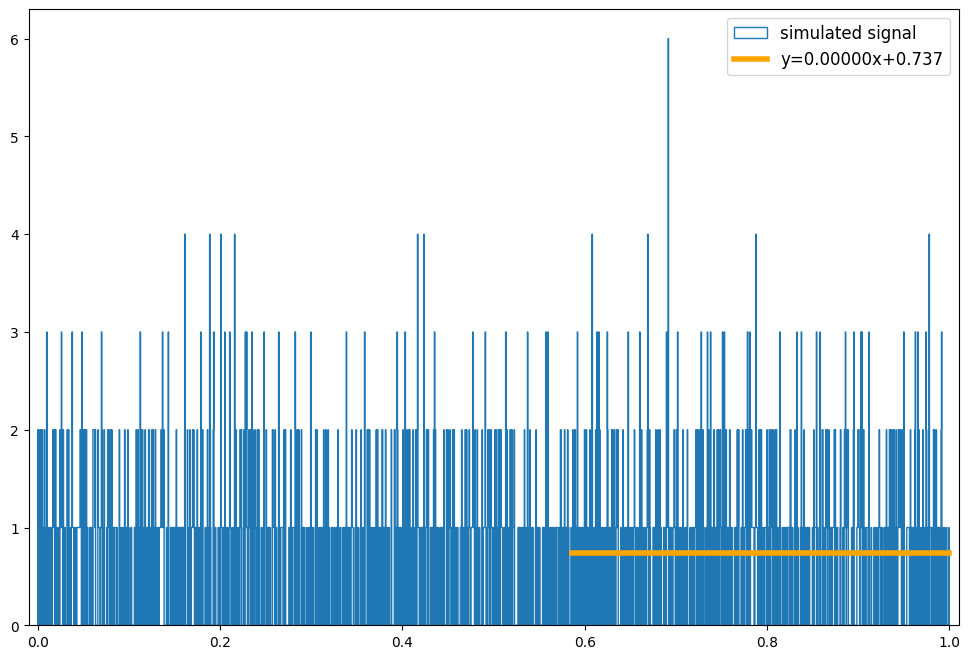

In [ ]:
_ = simulation_fitting(0.7,2048,1200,"yes")

## Now running the pull_sim_statistics that run the given number of simulations

### According to the timing test at the end of this notebook, simulating and obtaining statistics for 1000 distributions takes around 15 minutes (on my computer).
#### Remember if you want to know how the simulation is coming along as it is running to change the verbose to "yes" before running

In [ ]:
#Obtains: the statistics for a baselne of 100 counts
stats_100 = pull_sim_statistics(100,1000,1200,"no")
stats_100.to_csv("stats_100.csv")
stats_10 = pull_sim_statistics(10,1000,1200,"no")
stats_10.to_csv("stats_10.csv")
stats_5 = pull_sim_statistics(5,1000,1200,"no")
stats_5.to_csv("stats_5.csv")

#### Simulations based on time. Change the rate to adjust the timeframe of all the simulatioms

In [ ]:
baseline_halfday  = 0.15
#Obtains: the statistics for a baselne of s (about 1 week of real data)
stats_1week = pull_sim_statistics(14*baseline_halfday,1000,1200,"no")
stats_1week.to_csv("stats_1week.csv")
stats_3week = pull_sim_statistics(42*baseline_halfday,1000,1200,"no")
stats_3week.to_csv("stats_3week.csv")
stats_5week = pull_sim_statistics(70*baseline_halfday,1000,1200,"no")
stats_5week.to_csv("stats_5week.csv")

## 1000 Simulation Histogram
Plot Histograms of the spread of the dataframe values change first dataframe and guesser according to change which simulation is used

In [ ]:
def gauss_fitti(binning, counts, initial_guess):
    bin_mids = (binning[:-1] + binning[1:])/2.
    parameters, _ = curve_fit(pana_gauss, bin_mids, counts, p0=initial_guess)
    media = parameters[0]
    desvi = parameters[1]

    return media,desvi

def pana_gauss(x, u , sigma):
    '''function that defines the gauss function to fit parameters
       u     - mean of the function
       sigma - standard deviation
       x.    -      input'''

    c = np.sqrt(2 * np.pi)
    return np.exp(-0.5 * ((x-u)/ sigma)**2) / sigma / c

In [ ]:
def plotter(dataf, naming="gen", create_figures="yes"):

  base_vals  = []
  basecols=["Arithmetic_Mean_red","fit_Baseline_red"]
  for col in basecols:
      baselines, bines,_ = plt.hist(dataf[col],bins=50, density = "True",
                          histtype='step')
      gauss_b,_ = gauss_fitti(bines,baselines,(80,4))
      base_vals.append(gauss_b)

  plt.title("Baseline Values Distribution from a Simulated %s Baseline" %naming)
  plt.legend(["%s : %.5f" %(i,j) for i,j in zip(basecols, base_vals)])
  if create_figures =="yes":
    plt.show()
  plt.savefig("Baseline_Vals_%s.png" %(naming))
  plt.close()

  err_vals  = []
  errcols=["Standard_Deviation","fit_Error","Standard_Deviation_red","fit_Error_red"]
  for col in errcols:
      baselines, bines,_ = plt.hist(dataf[col],bins=50, density = "True",
                          histtype='step')
      gauss_b,_ = gauss_fitti(bines,baselines,(7,1))
      err_vals.append(gauss_b)

  plt.title("Baseline Errors Distribution from a Simulated %s Baseline" %naming)
  plt.legend(["%s : %.5f" %(i,j) for i,j in zip(errcols, err_vals)])
  if create_figures =="yes":
    plt.show()
  plt.savefig("Baseline_Errs_%s.png" %(naming))
  plt.close()

  pull_vals  = []
  pullcols=["arith_Pull_red","fit_Pull_red"]
  for col in pullcols:
      baselines, bines,_ = plt.hist(dataf[col],bins=50, density = "True",
                          histtype='step')
      gauss_b,_ = gauss_fitti(bines,baselines,None)
      pull_vals.append(gauss_b)

  plt.title("Baseline Pulls Distribution from a Simulated %s Baseline" %naming)
  plt.legend(["%s : %.5f" %(i,j) for i,j in zip(pullcols, pull_vals)])
  if create_figures =="yes":
    plt.show()
  plt.savefig("Baseline_Pulls_%s.png" %(naming))
  plt.close()
  return base_vals, err_vals, pull_vals

In [ ]:
baseline, error, pull = plotter(stats_100, "basse=100","no")
printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(baseline, error) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)

Values for simulated week of data taking at different cuts
Baseline estimation: 99.99643 +/- 9.99135
Baseline estimation: 99.99618 +/- 9.99135


In [ ]:
baseline, error, pull = plotter(stats_10, "base=10","no")
printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(baseline, error) ]
print("Values for simulated 3week of data taking at different cuts")
for i in printer:
  print(i)

Values for simulated 3week of data taking at different cuts
Baseline estimation: 9.99559 +/- 3.16353
Baseline estimation: 9.99547 +/- 3.16353


In [ ]:
baseline, error, pull = plotter(stats_5, "base=5","no")
printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(baseline, error) ]
print("Values for simulated 5week of data taking at different cuts")
for i in printer:
  print(i)

Values for simulated 5week of data taking at different cuts
Baseline estimation: 4.99945 +/- 2.23687
Baseline estimation: 4.99940 +/- 2.23687
